---

This notebook contains code to re-create **Figure 8** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, D. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
from tqdm import tqdm, tqdm_notebook

In [2]:
from celerite_base import *
from faraday_stuff import *

In [3]:
pl.rcParams['figure.figsize'] = [20, 5]
pl.rcParams['figure.dpi'] = 300

---
### Create data

In [4]:
nsrc = 2
p0 = np.ones(nsrc)
phi0 = np.array([120.,130.])

In [5]:
def fd_thin(l2,phi,p0):
    
    q = p0*np.cos(2*phi*l2)
    u = p0*np.sin(2*phi*l2)
    
    return q,u

In [6]:
const_c = 3e8

nu_min = 0.58e9
nu_max = 2.50e9

l2_min = (const_c/nu_max)**2
l2_max = (const_c/nu_min)**2

# make data regularly spaced in frequency:
nu = np.linspace(nu_min, nu_max, 512)
l2 = (const_c/nu)**2

# make data regularly spaced in lambda^2:
t1 = np.linspace(l2_min, l2_max, 512)

In [7]:
stokesQ = 0.
stokesU = 0.
for i in range(0,nsrc):
    
    q,u = fd_thin(l2,phi0[i],p0[i])
    
    stokesQ+=q
    stokesU+=u

In [8]:
noise = 0.05
stokesQn = stokesQ + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ))
stokesUn = stokesU + np.random.normal(loc =0.0, scale=noise, size = len(stokesU))

---
### Fit model

In [10]:
GP = MyCelerite(noise)
GP.celerite_optimize(l2, stokesQn, stokesUn)  # fit to original frequency sampling
mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, t1)

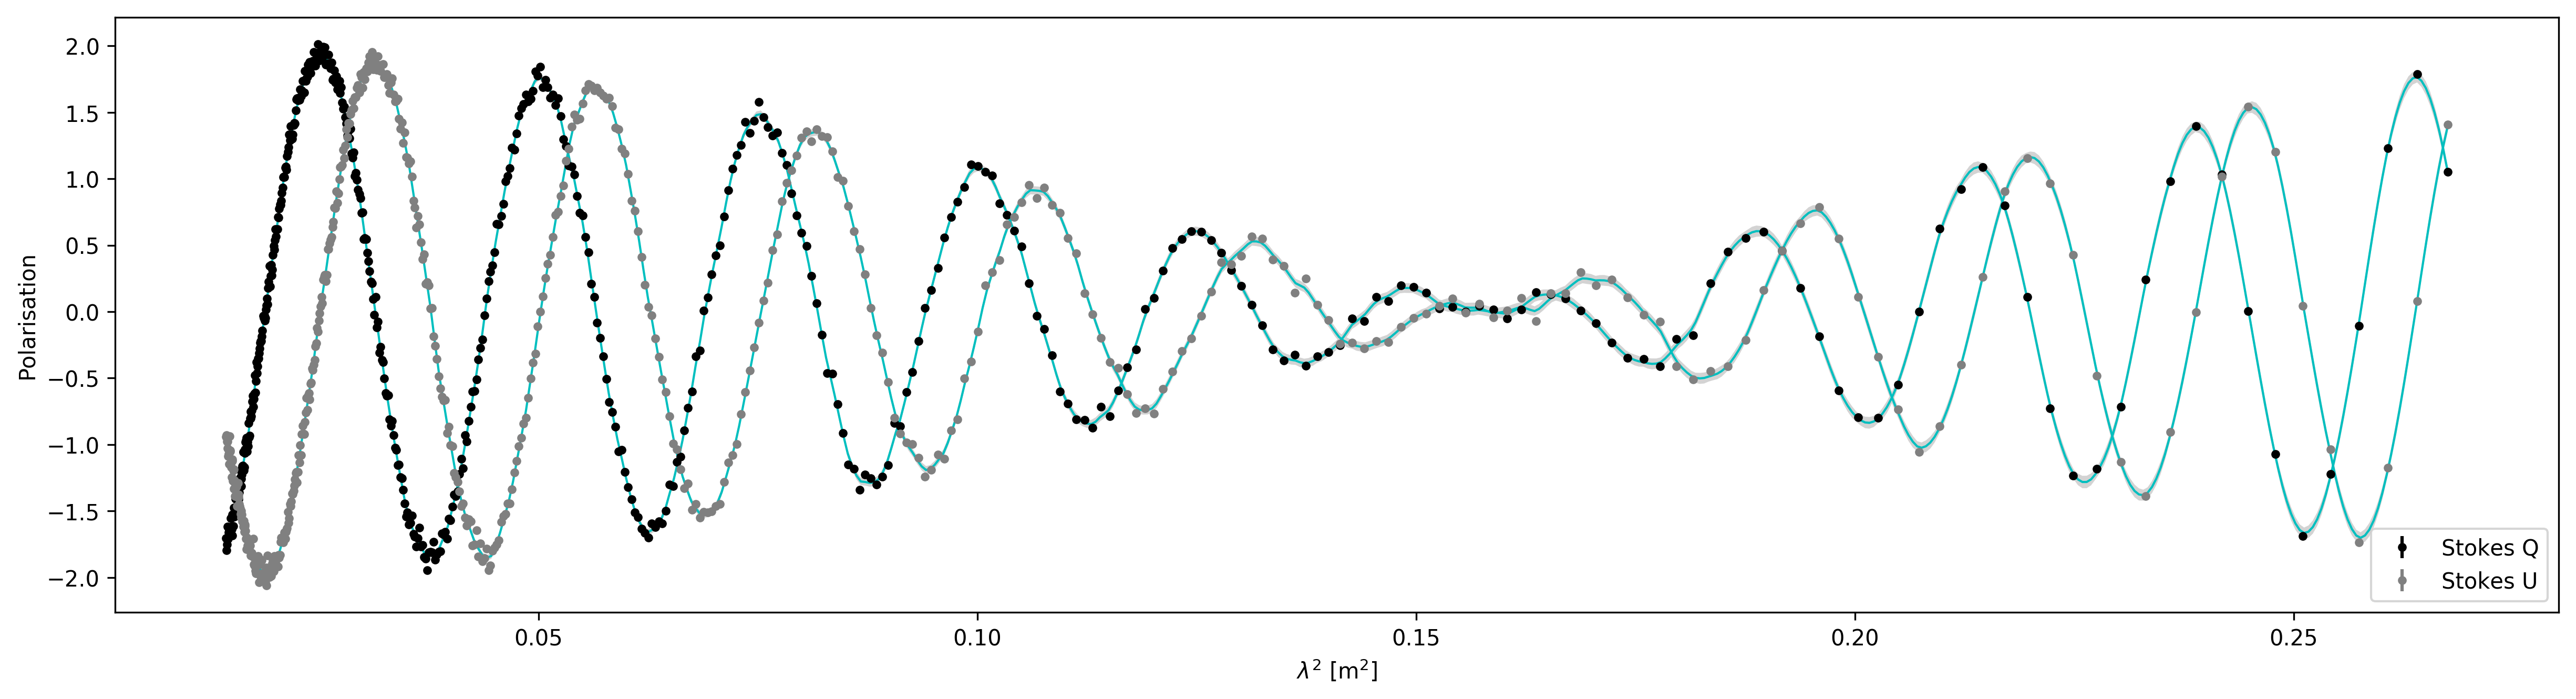

In [11]:
ax2 = pl.subplot(111)

ax2.plot(t1, mu_q, linestyle='-', color = 'c', lw=1.0)
ax2.plot(t1, mu_u, linestyle='-', color = 'c', lw=1.0)

ax2.fill_between(t1,mu_q-std_q,mu_q+std_q, facecolor='lightgray')
ax2.fill_between(t1,mu_u-std_u,mu_u+std_u, facecolor='lightgray')

ax2.errorbar(l2[::-1],stokesQn[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(l2[::-1],stokesUn[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")
ax2.set_xlabel(r"$\lambda^2$ [m$^2$]")
ax2.legend()
pl.show()

---
### Make Faraday depth spectra

In [12]:
fspec1 = [];fspec2 = [];fspec3 = []
rmtf1 = [];rmtf2 = [];rmtf3 = []

w1 = np.ones(len(stokesQ))

var_gp = np.ones(len(mu_q))+std_q**2
w2 = 1./var_gp

phi = np.linspace(-500,500,10000)

for i in range(0,len(phi)):
    fspec1.append(calc_f(phi[i],l2[::-1],stokesQn[::-1],stokesUn[::-1],w1))
    fspec2.append(calc_f(phi[i],t1,mu_q,mu_u,w2))
    
    rmtf1.append(calc_r(phi[i],l2[::-1],w1))
    rmtf2.append(calc_r(phi[i],t1,w2))
    
fspec1 = np.array(fspec1)
fspec2 = np.array(fspec2)

rmtf1 = np.array(rmtf1)
rmtf2 = np.array(rmtf2)

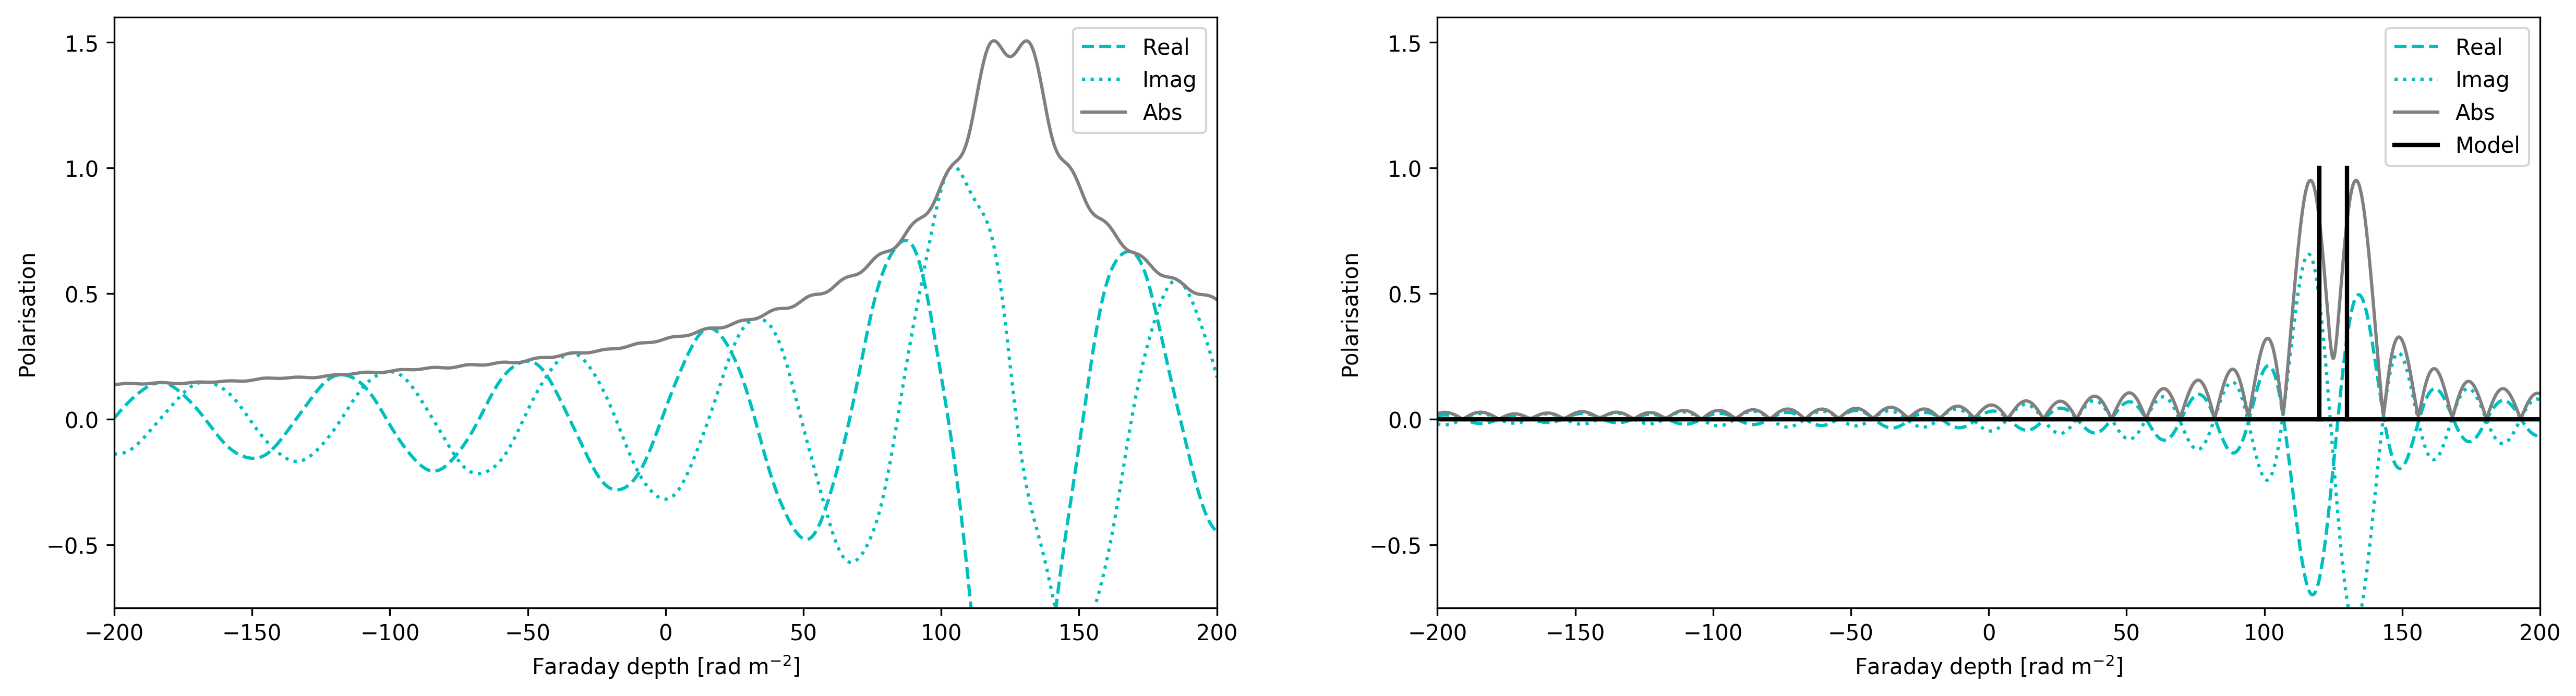

In [13]:
pl.subplot(121)
pl.plot(phi,np.real(fspec1),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec1),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec1),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
pl.ylim(-0.75,1.6)
pl.ylabel("Polarisation")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(122)
pl.plot(phi,np.real(fspec2),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec2),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec2),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
pl.ylim(-0.75,1.6)
pl.ylabel("Polarisation")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

for i in range(nsrc):
    pl.plot([phi0[i],phi0[i]],[0.,p0[i]],ls='-',lw=2.,c='black')
pl.plot(phi,np.zeros(len(phi)),ls='-',lw=2.,c='black',label="Model")

pl.legend()

pl.show()

---
#### END